## Step one Detect if there is fire or not



In [1]:
from PIL import Image
import requests
import torch
import torchvision.transforms as T
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, AutoModel
import cv2

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


2025-07-30 00:46:35.821982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753836396.068546      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753836396.151424      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

To detect presence of fire i will simply use clip to get similarity between the two texts and pick which (in relathion to the image input) got the higher similarity is the classified class 

Little too simple yes ,it work fine for now but must be improved later

In [3]:
def detectfile(url):
    image = Image.open(url)
    text_prompts = [ #forest?
    "a normal forest scene",
        "a fire or smoke in a forest"
    ]  
    inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True,do_resize=True, size=224)
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    #1 fire 0 no fire
    return 1 if probs[0][0]<probs[0][1] else 0,probs
        
    

In [4]:
res,prob=detectfile("/kaggle/input/surefirepics/notsafe1.jpg")
print(f"Fire Detected? {bool(res)} | Probabilities: {prob}")


Fire Detected? True | Probabilities: tensor([[0.0027, 0.9973]], grad_fn=<SoftmaxBackward0>)


## step 2 localise fire section

## DINOv2 + Feature Similarity Map

### What is Dinov2
Self-DIstillation with NO labels
It’s a self-supervised vision foundation model

### What tasks is it used for 
class/semantic labeling/ Image segmentation (what we will used if for here )/object detection/d3 redefinritoon
It's a vision transformer that generates dense patch-level embeddings, good for tasks like:

Image classification

Object detection

Semantic segmentation

Anomaly detection

Image retrieval

### What is the flow of the input to output

Input image ➡️ Augmentations (viws) : we take an image and apply a bunch of ttansformations (crop rotate ect) that way w
we get differnet views of the same image 

Patch embeddings computed (ViT backbone) no idea yet why who what

Self-distillation loss: student tries to match teacher's representation  nope dont get it either yet

Final output: feature maps or global descriptors   (we get overal feature map from the teach and patch level features maps)


How it is used in this project

detect the regions of fire in the image
Howwww






### help

Extract patch-wise features from DINOv2.


Compare each patch to the global representation (e.g., from a normal scene).

Compute similarity → low similarity = anomaly → fire region.

Visualize this as a heatmap (Anomaly Map + Color Overlay).

## what we want to do


Take an image that contains fire.

Use DINOv2 to extract patch-level embeddings.

Compare these patches to detect anomalies (like fire).

Visualize the anomaly regions as a heatmap.



## Code Skeleton with DINOv2

### 1. Load the DINOv2 model and process image


In [5]:

# the model
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# the testing image that we detected has fire but we dont know where
img = Image.open("/kaggle/input/surefirepics/notsafe1.jpg").convert("RGB")
inputs = processor(images=img, return_tensors="pt",do_resize=True, size=224).to(device)  #we must resize to 224


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### 2. Extract Patch Features


In [6]:
with torch.no_grad():
    outputs = model(**inputs)
    patch_tokens = outputs.last_hidden_state[0]  # (num_tokens, dim)


 The image is cropped to 196 patches ==224/16  =14  (vit is 16 by 16)
 Each of those 196 patches gets its embedding of size ( 768)
 The cls token is the global image mebedding : (sparse detection ? )
 atch_tokens[0]     → CLS token (represents the whole image)
patch_tokens[1:197] → 196 patch tokens (each patch's embedding)

### 3. Compare Patches to Global (or Normal) Embedding

In [36]:


normal_image = "/kaggle/input/smoke-fire-detection-yolo/data/test/images/AoF06726.jpg"  #image with no fire for reference
imgnormal = Image.open(normal_image).convert("RGB")
inputs = processor(images=img, return_tensors="pt",do_resize=True, size=224).to(device)
with torch.no_grad():
    outputsn = model(**inputs)
    normal_tokens = outputsn.last_hidden_state[0]  # (num_tokens, dim)


#  CLS 
cls_normal = normal_tokens[0]       # (dim,)


To detect regions with fire we need to use as a reference as image of same context == forest with  no fire and compare the embeddings so 
in our original image (notsafe) that has some fire we can detect teh regions we no fire , we are using sparse /global detection (rathe than dense which works pixel by pixel and since images are not exactly the same scene of the forest this can cause some issues) then dinov5 does his thing for feature detection which i am not yet sure sure how and detect the regions that has like big difference 

In [8]:

cls_normal = patch_tokens[0]  # (dim,)
patches = patch_tokens[1:]        # (n_patches, dim)

# compute cosine similarity
similarity = torch.nn.functional.cosine_similarity(patches, cls_normal.unsqueeze(0), dim=1)


### 4.Vislize the heatmap

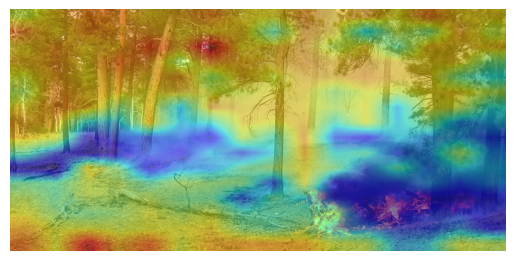

In [11]:
# convert similarity to anomaly score 
anomaly_score = 1 - similarity.cpu().numpy()

# normalize
anomaly_score = (anomaly_score - anomaly_score.min()) / (anomaly_score.max() - anomaly_score.min())

n_patches = patch_tokens[1:].shape[0]  # number of patch tokens
side = int(n_patches ** 0.5) 

if side * side != n_patches: #fixed the 14*14 thing
    raise ValueError(f"Unexpected patch count: {n_patches} is not a square.")

heatmap = anomaly_score.reshape(side, side)



heatmap_resized = cv2.resize(heatmap, img.size)

# Overlay heatmap
plt.imshow(img)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()


### How DINOv2 Detected Fire Regions
we are working patches level (not pixels ) when getting the embeddingof those  patches we are getting the semantic signicance also , so when we also used dino on the reference pic with no fire we got the compare the patches by cosine sim (we comparing patch per patch) for the ones with fire the diff is gonna be big , we like that managed to capture the regions aka patches with fire in em
ps choice of reference pic is important ..duh